#Install


In [ ]:
!pip install -q transformers
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.7 MB/s eta 0:00:00
Looking in indexes: https://test.pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.4 MB/s

#Drive Code


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your Football_Stage1 folder
folder_path = '/content/drive/My Drive/Football_Stage1/'

# Define the name of the ZIP file
zip_file_name = 'custom-model_1696671860.zip'

# Define the destination directory in your Colab environment
destination_dir = '/content/'

# Unzip the file
import zipfile
with zipfile.ZipFile(folder_path + zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print("File has been downloaded and unzipped successfully.")


Mounted at /content/drive
File has been downloaded and unzipped successfully.


#ImageDetection


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


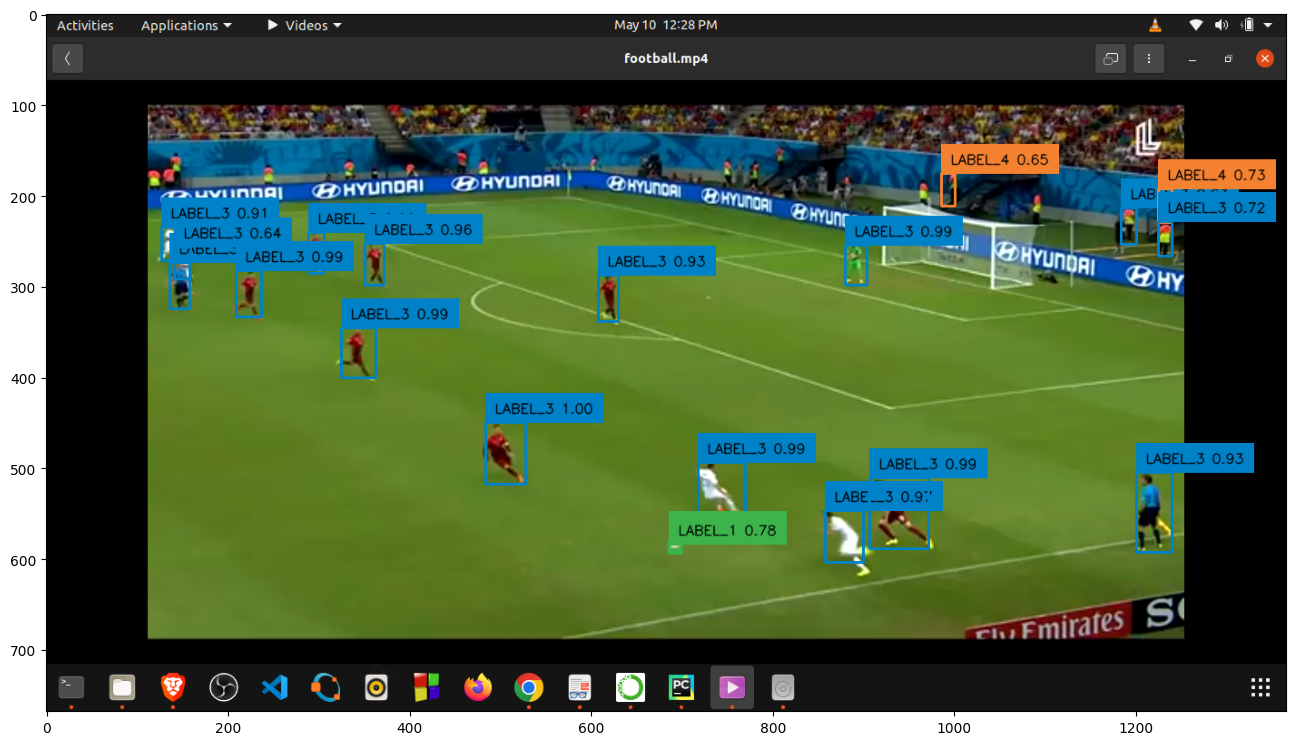

In [ ]:
import os
import torch
import cv2
import torchvision.transforms as T
from transformers import DetrForObjectDetection, DetrImageProcessor
import supervision as sv

# Define the paths to the saved model and custom image
MODEL_PATH = "/content"
IMAGE_PATH = "/content/1.png"  # Replace with the path to your custom image

# Load the pre-trained model
loaded_model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model.to(device)

# Load and preprocess the custom image
image = cv2.imread(IMAGE_PATH)
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
inputs = image_processor(images=image, return_tensors='pt').to(device)

# Make predictions on the custom image
with torch.no_grad():
    outputs = loaded_model(**inputs)

# Post-process the results
target_sizes = torch.tensor([image.shape[:2]]).to(device)
results = image_processor.post_process_object_detection(
    outputs=outputs,
    threshold=0.5,  # Adjust the threshold as needed
    target_sizes=target_sizes
)[0]

# Convert results to Supervisely format
detections = sv.Detections.from_transformers(transformers_results=results)

# Annotate and visualize the results
labels = [f"{loaded_model.config.id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
box_annotator = sv.BoxAnnotator()
annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Display the annotated image
%matplotlib inline
sv.show_frame_in_notebook(annotated_image, (16, 16))


In [ ]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor

# Replace 'path/to/custom-model' with the actual path to the saved model
MODEL_PATH = '/content'
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.eval()

# Load id2label
# Assuming that id2label is a dictionary mapping class IDs to class names
id2label = {1: 'ball', 2: 'goalkeeper', 3: 'player', 4: 'refree'}  # Replace with your actual mapping

# Image processor
image_processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


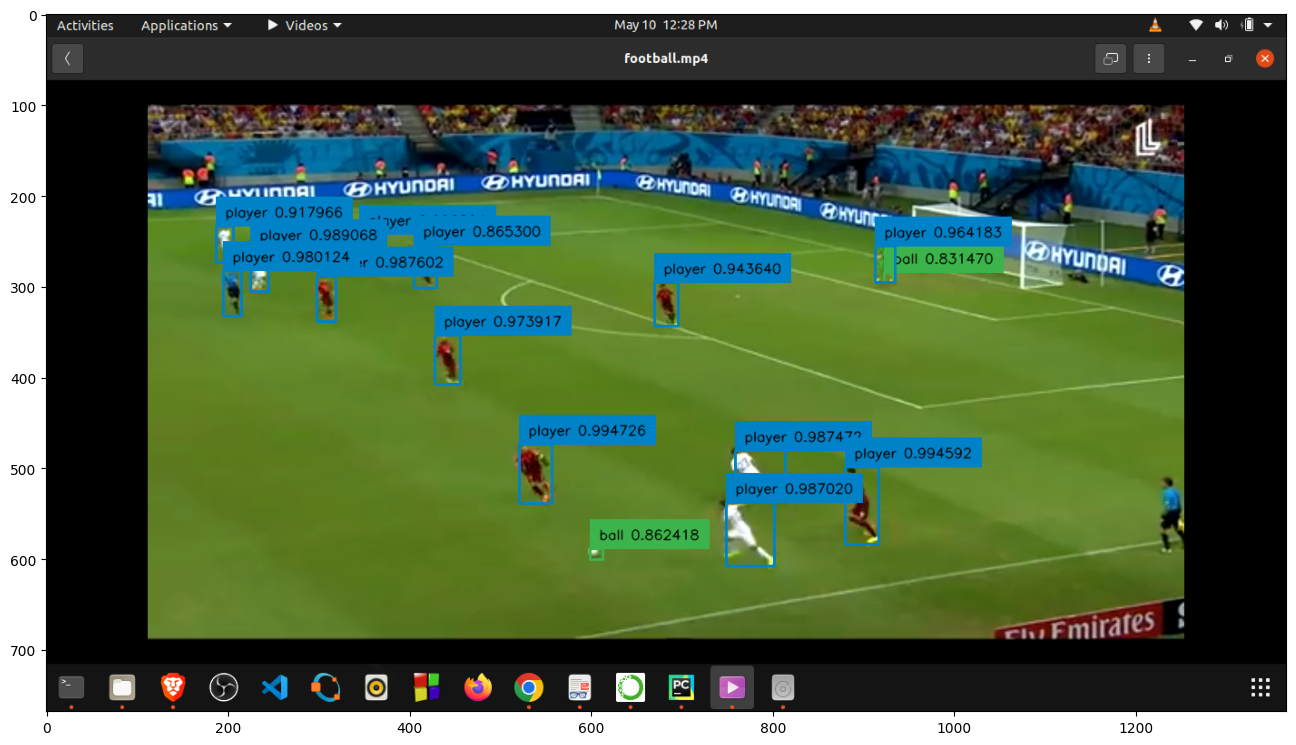

In [ ]:
import cv2
import supervision as sv

# Replace 'path/to/custom-image.jpg' with the actual path to your custom image
IMAGE_PATH = '/content/2.png'

# Load and preprocess the image
image = cv2.imread(IMAGE_PATH)
inputs = image_processor(images=image, return_tensors='pt').to(device)


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(**inputs)

# Post-process the results
target_sizes = torch.tensor([image.shape[:2]]).to(device)
results = image_processor.post_process_object_detection(outputs, threshold=0.8, target_sizes=target_sizes)[0]

# Annotate the image
detections = sv.Detections.from_transformers(transformers_results=results)

# Annotate the image with correct id2label or 'unknown' if class ID not in id2label
labels = [f"{id2label.get(class_id, 'unknown')} {confidence:0f}" for _, confidence, class_id, _ in detections]

box_annotator = sv.BoxAnnotator()
annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Display the annotated image
%matplotlib inline
sv.show_frame_in_notebook(annotated_image, (16, 16))

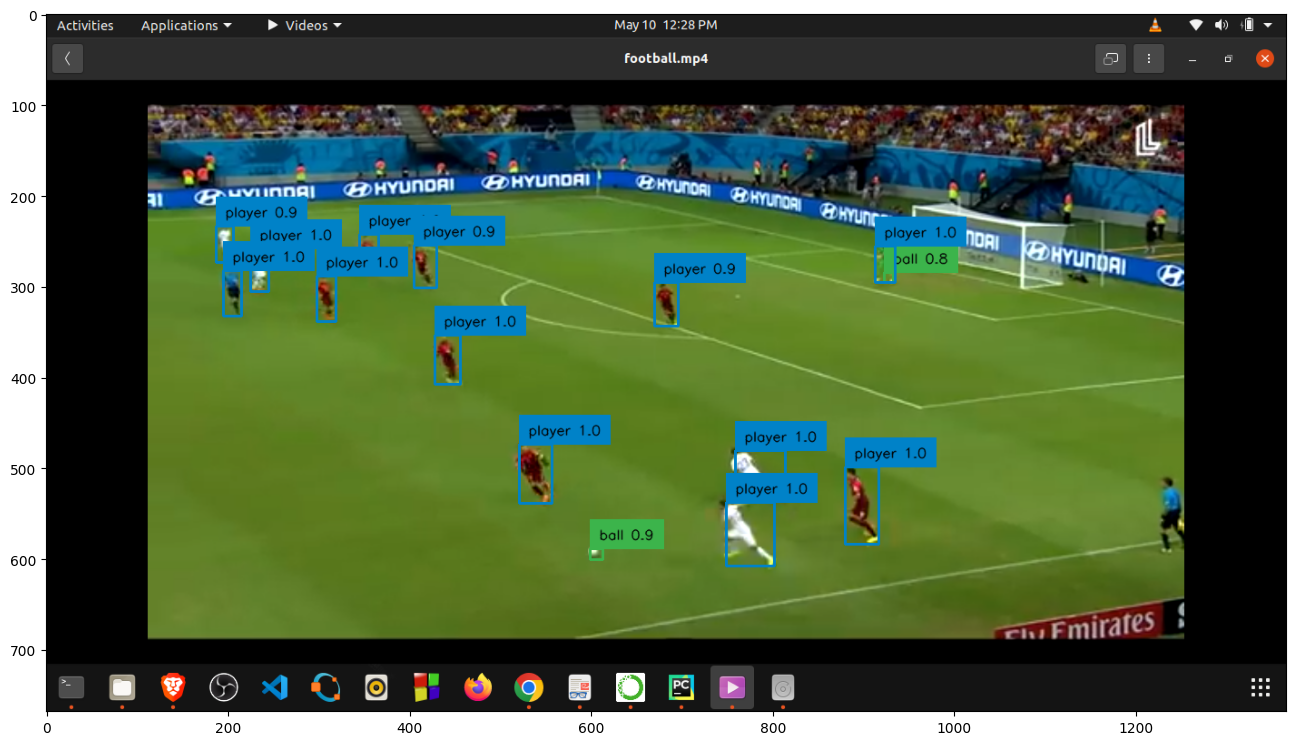

In [ ]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor

# Replace 'path/to/custom-model' with the actual path to the saved model
MODEL_PATH = '/content'
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.eval()

# Load id2label
# Assuming that id2label is a dictionary mapping class IDs to class names
# Remove the 'referee' label and include 'goalkeeper' as part of 'player'
id2label = {1: 'ball', 2: 'player', 3: 'player'}  # Modify as needed

# Image processor
image_processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

import cv2
import supervision as sv

# Replace 'path/to/custom-image.jpg' with the actual path to your custom image
IMAGE_PATH = '/content/2.png'

# Load and preprocess the image
image = cv2.imread(IMAGE_PATH)
inputs = image_processor(images=image, return_tensors='pt').to(device)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(**inputs)

# Post-process the results
target_sizes = torch.tensor([image.shape[:2]]).to(device)
results = image_processor.post_process_object_detection(outputs, threshold=0.8, target_sizes=target_sizes)[0]

# Annotate the image
detections = sv.Detections.from_transformers(transformers_results=results)

# Annotate the image with correct id2label or 'unknown' if class ID not in id2label
labels = [f"{id2label.get(class_id, 'unknown')} {confidence:.1f}" for _, confidence, class_id, _ in detections]

box_annotator = sv.BoxAnnotator()
annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Display the annotated image
%matplotlib inline
sv.show_frame_in_notebook(annotated_image, (16, 16))


#Video Tracking

In [ ]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor
import cv2
import supervision as sv

# Replace 'path/to/custom-model' with the actual path to the saved model
MODEL_PATH = '/content'
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.eval()

# Load id2label
# Assuming that id2label is a dictionary mapping class IDs to class names
# id2label = {1: 'ball', 2: 'goalkeeper', 3: 'player', 4: 'referee'}  # Replace with your actual mapping
id2label = {1: 'ball', 2: 'player', 3: 'player', 4: 'referee'}  # Replace with your actual mapping

# Image processor
image_processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Open the video file for reading
VIDEO_PATH = '/content/matchvid.mp4'  # Replace with the path to your input video
cap = cv2.VideoCapture(VIDEO_PATH)

# Define the codec and create a VideoWriter object to save the output video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter('/content/Output/output_video3.avi', fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

while True:
    ret, frame = cap.read()

    if not ret:
        break

    # Preprocess the frame
    inputs = image_processor(images=frame, return_tensors='pt').to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process the results
    target_sizes = torch.tensor([frame.shape[:2]]).to(device)
    results = image_processor.post_process_object_detection(outputs, threshold=0.8, target_sizes=target_sizes)[0]

    # Annotate the frame
    detections = sv.Detections.from_transformers(transformers_results=results)
    labels = [f"{id2label.get(class_id, 'unknown')} {confidence:.1f}" for _, confidence, class_id, _ in detections]

    box_annotator = sv.BoxAnnotator()
    annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections, labels=labels)

    # Write the annotated frame to the output video
    output_video.write(annotated_frame)

# Release video capture and writer objects
cap.release()
output_video.release()

print("Video processing and annotation complete. Output video saved as 'output_video.avi'.")


Video processing and annotation complete. Output video saved as 'output_video.avi'.
